old title: klarizsofiMice

0_003_dt_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from scipy import signal
import statsmodels.api as sm
import math
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.signal import resample
from utils.plotting import plot_trajectory
import statistics

#### -1. open original df, check if trajectories are equal in rows from same session, check that df contains mouse data

In [2]:
# это df c данными мышей
#data_frame_with_cells = pd.read_pickle("C:\\Users\\Lenovo\\Desktop\\навигация\\neuro\\SORTED_CLUSTERS\\sorted_clusters.pkl")
df_all = pd.read_pickle("C:\\Users\\Lenovo\\Desktop\\навигация\\neuro\\SORTED_CLUSTERS\\sorted_clusters.pkl")

In [162]:
# df_mice = pd.read_pickle("C:\\Users\\Lenovo\\Desktop\\навигация\\neuro\\SORTED_CLUSTERS\\all_mice_df.pkl")
# df_rats = pd.read_pickle("C:\\Users\\Lenovo\\Desktop\\навигация\\neuro\\SORTED_CLUSTERS\\all_rats_df.pkl")
#Получается, в df_all лежат сессии мышей
# mice_sess = df_mice['session_id'].unique()
# rats_sess = df_rats['session_id'].unique()
# df_sess = df_all['session_id'].unique()
# sim_df_mice = len(set(df_sess).intersection(set(mice_sess))) / len(set(df_sess)) * 100
# sim_df_rats = len(set(df_sess).intersection(set(rats_sess))) / len(set(df_sess)) * 100
# print(sim_df_mice)
# print(sim_df_rats)

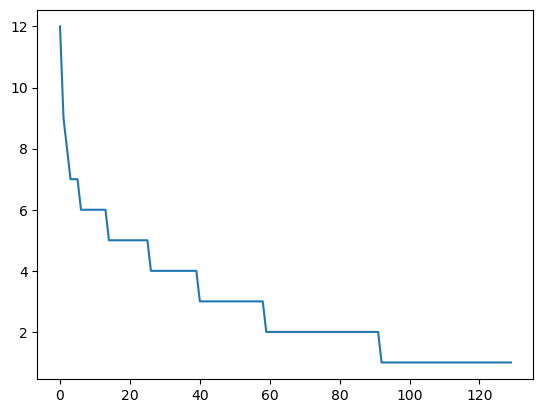

In [30]:
plt.plot(range(len(df_all['session_id'].value_counts())),df_all['session_id'].value_counts())

In [22]:
#how many neurons in each session
df_all['session_id'].value_counts()

M11_2018-03-12_17-58-58_of    12
M5_2018-02-26_16-47-52_of      9
M5_2018-02-15_17-23-36_of      8
M5_2018-02-16_15-57-18_of      7
M5_2018-03-01_13-29-52_of      7
                              ..
M2_2018-02-22_15-25-44_of      1
M3_2018-02-19_14-19-51_of      1
M3_2018-02-22_16-00-01_of      1
M4_2018-02-20_16-33-10_of      1
M9_2018-03-20_15-25-22_of      1
Name: session_id, Length: 130, dtype: int64

check whether trajectory_x are equal in rows from same session

In [8]:
df_m5_36 = df_all.loc[df_all['session_id']=='M5_2018-02-15_17-23-36_of']
df_m5_36.sample(3)
#see columns trajectory_x, trajectory_y

session_id  cluster_id  \
6   M5_2018-02-15_17-23-36_of           7   
12  M5_2018-02-15_17-23-36_of          13   
14  M5_2018-02-15_17-23-36_of          15   

                                           position_x  \
6   [39.30687954545454, 30.350731818181824, 22.787...   
12  [77.89189090909092, 77.89189090909092, 73.9262...   
14  [73.9262090909091, 73.9262090909091, 73.926209...   

                                           position_y  \
6   [99.72998636363639, 98.58512272727272, 98.7621...   
12  [94.70430454545455, 94.70430454545455, 95.0382...   
14  [95.03828181818183, 95.03828181818183, 95.0382...   

                                                   hd  \
6   [-119.69744147745679, -95.8991895385417, -89.0...   
12  [-123.04445007083343, -123.04445007083343, -12...   
14  [-124.19408027632899, -124.19408027632899, -12...   

                                          firing_maps  \
6   [[3.9309849605916973, 3.8172259168219917, 3.79...   
12  [[14.413624670787259, 12.987723966231039, 11.1...   
14  [[1.2235985720874003, 1.1808155484925116, 1.27...   

                                         firing_times  \
6   [35265.0, 42748.0, 59628.0, 61166.0, 69272.0, ...   
12  [2018.0, 2372.0, 5142.0, 6743.0, 6849.0, 7148....   
14  [5074.0, 5261.0, 5423.0, 5552.0, 5660.0, 7903....   

                                        trajectory_hd  \
6   0       -121.500189
1       -123.150933
2     ...   
12  0       -121.500189
1       -123.150933
2     ...   
14  0       -121.500189
1       -123.150933
2     ...   

                                         trajectory_x  \
6   0        80.448095
1        79.224857
2       ...   
12  0        80.448095
1        79.224857
2       ...   
14  0        80.448095
1        79.224857
2       ...   

                                         trajectory_y  \
6   0        94.429395
1        94.538441
2       ...   
12  0        94.429395
1        94.538441
2       ...   
14  0        94.429395
1        94.538441
2       ...   

                                     trajectory_times  
6   0           0.006842
1           0.038151
2   ...  
12  0           0.006842
1           0.038151
2   ...  
14  0           0.006842
1           0.038151
2   ...

In [59]:
k = []
for i in df_m5_36['trajectory_x']:
    k.append(len(i))
print(k)
df_m13_20 = df_all.loc[df_all['session_id']=='M13_2018-04-23_09-34-20_of']

[41384, 41384, 41384, 41384, 41384, 41384, 41384, 41384]


не все записи одинаково хороши. например, 1, 7 пустые

#### 0. Open preprocessed df

In [2]:
resampled_df = pd.read_pickle('M13_2018-04-23_09-34-20_of_17.pkl') 

In [57]:
resampled_df.isnull().sum().sum()

0

In [3]:
len(resampled_df)

42042

#### 0.5. Functions

In [8]:
#таблица с траекторией
def makebasDF(n):
    x = df_all['trajectory_x'].iloc[n] 
    y = df_all['trajectory_y'].iloc[n]
    time = df_all['trajectory_times'].iloc[n]
    zipped = list(zip(time,x, y))

    df = pd.DataFrame(zipped, columns=['time', 'x', 'y'])
    #df = df.loc[df['time']<=1000]
    #print(df)
    #plot_trajectory(df['x'],df['y'])
    return df
def makebasNpfromRow(row):
    x = row['trajectory_x']
    y = row['trajectory_y']
    time = row['trajectory_times']
    tr_np = np.dstack((time, x, y))
    return tr_np[0]

def rescale_coord(data, new_min, new_max):
    min_old_x, max_old_x = np.min(data), np.max(data)
    data_rescaled = ((data - min_old_x) / (max_old_x - min_old_x)) * (new_max - new_min) + new_min
    return data_rescaled

#near corner: code 50
#near wall (not near corner): code 5
#center: code 0
def sort_walls_area_simple(tr, border_tr, wall_percent=0.1): 
    ylen = border_tr['ymax'] - border_tr['ymin'] 
    xlen = border_tr['xmax'] - border_tr['xmin'] 
    xl = border_tr['xmin'] + xlen * wall_percent
    xr = border_tr['xmax'] - xlen * wall_percent
    yd = border_tr['ymin'] + ylen * wall_percent
    yu = border_tr['ymax'] - ylen * wall_percent

    tr['near_wall'] = 0.
    for i in range(len(tr)):     
        if tr['x'].iloc[i] < xl:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 50
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 50
            else:
                tr['near_wall'].iloc[i] = 5
        elif tr['x'].iloc[i] > xr:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 50
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 50
            else:
                tr['near_wall'].iloc[i] = 5
        elif tr['y'].iloc[i] > yu:
            tr['near_wall'].iloc[i] = 5
        elif tr['y'].iloc[i] < yd:
            tr['near_wall'].iloc[i] = 5
    return tr


#### 1. preprocessing

##### 1.1 open firing time and trajectory time

M13_2018-04-23_09-34-20_of
cluster 17

In [7]:
dat1=df_all[120:121]
traj_time = dat1['trajectory_times'].iloc[0]
print('sampling rate of trajectory:',len(traj_time)/max(traj_time))
#sampling rate is 30 samples / sec, time is in seconds
fire_time_old = dat1['firing_times'].iloc[0]
#fire_time = dat1['firing_times'].iloc[0] / 30000

sampling rate of trajectory: 30.083133307902084


##### 1.2 smoothing of neuro recording

In [8]:
#sampling rate of fire_time
max(fire_time_old) / max(traj_time)

30001.133089482897

In [9]:
for i in range(5):
    print(i)

0
1
2
3
4


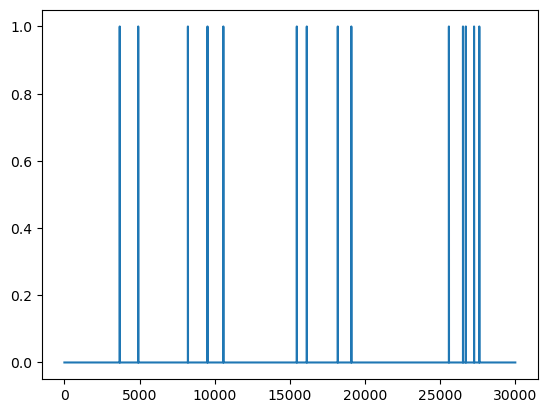

In [11]:
sigm = 0.01 * 30000
#0.015 too slow
fire_time_old= fire_time_old.astype(int)
l = max(fire_time_old) + 1
signal = np.zeros(l)
signal[fire_time_old] = 1
plt.plot(signal[3130000:3160000])

In [12]:
%time signal = gaussian_filter1d(signal, sigm)

CPU times: total: 1min
Wall time: 1min 7s


1472.8078


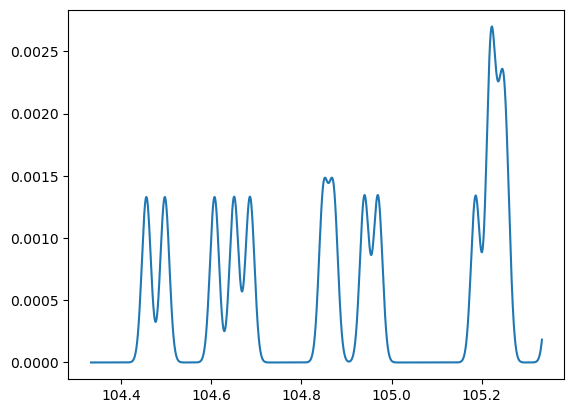

In [13]:
sign_time = np.arange(len(signal))
sign_time = sign_time / 30000
print(max(sign_time))
plt.plot(sign_time[3130000:3160000],signal[3130000:3160000])

##### 1.3 resample neuro recording and trajectory recording to 0.00333

#чтобы перевести время тректории и сигнала в 1 семплинг рейт нужно немного обрезать время, чтобы все начиналось и заканчивалась в 1 и то же время
#пусть это будет от 1 с до 1470 c

In [36]:
#max sign time
#(len(signal) - 1) / 30000

In [14]:
#compare dt in trejectory and neuro recordings
print('signal time')
print('min',min(sign_time))
print('max',max(sign_time))
print('dt',max(sign_time)/len(sign_time), '\n')
print('trajectory time')
print('min',min(traj_time))
print('max',max(traj_time))
print('dt', max(traj_time)/len(traj_time))


signal time
min 0.0
max 1472.8078
dt 3.333333257891644e-05 

trajectory time
min 0.037448266664458885
max 1472.7521746666657
dt 0.03324121825226647


In [15]:
#время с 0 с до 1400
tr_df = makebasDF(120)
tr_np = tr_df.to_numpy()
mask = (tr_np[:, 0] >= 0) & (tr_np[:, 0] <= 1400)
tr_np = tr_np[mask, :]

sign_np = np.dstack((sign_time, signal))
sign_np = sign_np[0]
#время от 1 с до 1400
mask = (sign_np[:, 0] >= 0) & (sign_np[:, 0] <= 1400)
sign_np = sign_np[mask, :]


In [16]:
new_dt = 0.00333
num_new_points = int (1400 / new_dt)

#блин мне порoю не хватает RAM для этой ячейки
#нужно взять не signal а sign_np!!!!!!!!!!!!!!!!!!!!!!!!! TODO 
%time new_sign = resample(sign_np[:,1], num_new_points, axis=0)

CPU times: total: 18.5 s
Wall time: 2min 13s


In [34]:
3130000 / 30000 * 300

31000.0

In [33]:
1 / new_dt

300.3003003003003

1401.3966666666668


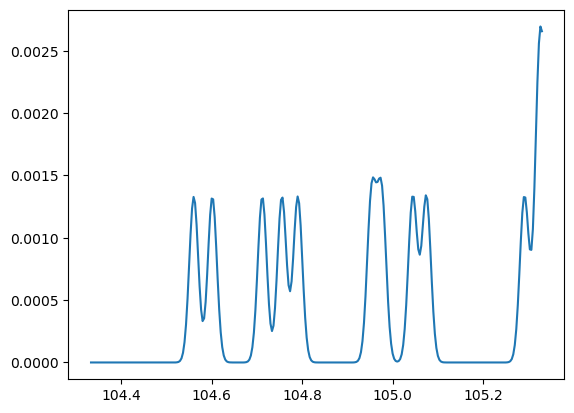

In [19]:
sign_time = np.arange(len(new_sign))
sign_time = sign_time / 300
print(max(sign_time))
plt.plot(sign_time[31300:31600],new_sign[31300:31600])
#время смещено на 1 секунду влево

In [20]:

resampled_dfnp = resample(tr_np[:, 1:], num_new_points, axis=0)
new_time = np.linspace(0, 1400, num_new_points)
#new_sign = resample(sign_np[:, 1:], num_new_points, axis=0)
resampled_df = pd.DataFrame({'time': new_time,
                                     'x': resampled_dfnp[:, 0], 
                                     'y': resampled_dfnp[:, 1],
                                    'signal'+str(int(dat1['cluster_id'])):new_sign})


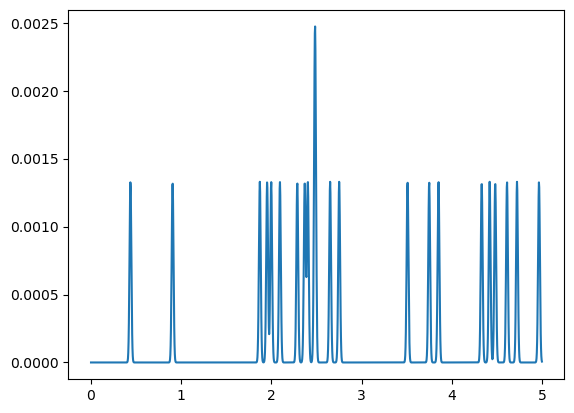

In [21]:
plt.plot(resampled_df.loc[resampled_df['time']<=5]['time'],resampled_df.loc[resampled_df['time']<=5]['signal17'])

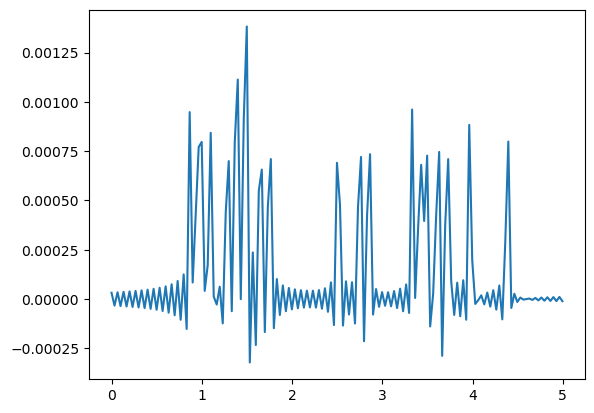

In [29]:
#старое смещенное на секунду
plt.plot(resampled_df.loc[resampled_df['time']<=5]['time'],resampled_df.loc[resampled_df['time']<=5]['signal17'])

In [22]:
resampled_df.to_pickle('new_M13_2018-04-23_09-34-20_of_17.pkl')

In [52]:
df_m13_20 = df_all.loc[df_all['session_id']=='M13_2018-04-23_09-34-20_of']
df_m13_20.to_pickle('df_all_M13_2018-04-23_09-34-20_of.pkl')

##### 1.4 add the rest neural recordings

In [4]:
resampled_df = pd.read_pickle('new_M13_2018-04-23_09-34-20_of_17.pkl') 
df_m13_20 = pd.read_pickle('df_all_M13_2018-04-23_09-34-20_of.pkl') 
df_m13_20 = df_m13_20.reset_index(drop=True)

In [5]:
print(len(resampled_df)/1400)

300.3


In [6]:
resampled_df

time           x          y      signal17   signal6  signal12
0          0.00000   95.075018   7.693317  6.071836e-10  0.001022  0.000077
1          0.00333  100.186379   6.587274 -6.029137e-10 -0.000185  0.000176
2          0.00666  103.843984   5.798661  5.987792e-10  0.000100  0.000274
3          0.00999  106.052412   5.325915 -5.947755e-10 -0.000068  0.000471
4          0.01332  106.896233   5.150192  5.908982e-10  0.000051  0.000720
...            ...         ...        ...           ...       ...       ...
420415  1399.98668   53.109383  16.836155 -6.307439e-10  0.001921  0.000391
420416  1399.99001   62.833622  14.709746  6.257187e-10  0.001879  0.000209
420417  1399.99334   72.204922  12.664988 -6.208559e-10  0.002085  0.000096
420418  1399.99667   80.887685  10.774176  6.161495e-10  0.001992  0.000049
420419  1400.00000   88.588777   9.100306 -6.115939e-10  0.002289  0.000015

[420420 rows x 6 columns]

###### 1.4.1 add signal 6

CPU times: total: 58.2 s
Wall time: 1min 4s
1472.7933


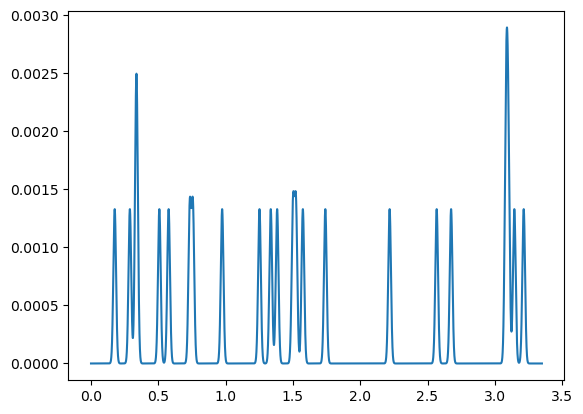

In [7]:
#firing time open
fire_time_old = df_m13_20.iloc[0]['firing_times']

#smoothing
sigm = 0.01 * 30000
fire_time_old= fire_time_old.astype(int)
l = max(fire_time_old) + 1
signal = np.zeros(l)
signal[fire_time_old] = 1
%time signal = gaussian_filter1d(signal, sigm)

#plot
sign_time = np.arange(len(signal))
sign_time = sign_time / 30000
print(max(sign_time))
plt.plot(sign_time[:100500],signal[:100500])

#cut time to interval 0s-1400s
tr_np = makebasNpfromRow(df_m13_20.iloc[0])
mask = (tr_np[:, 0] >= 0) & (tr_np[:, 0] <= 1400)
tr_np = tr_np[mask, :]

sign_np = np.dstack((sign_time, signal))
sign_np = sign_np[0]
#время от 1 с до 1400
mask = (sign_np[:, 0] >= 0) & (sign_np[:, 0] <= 1400)
sign_np = sign_np[mask, :]


In [8]:
new_dt = 0.00333
num_new_points = int (1400 / new_dt)

#блин мне порю не хватает RAM для этой ячейки
#нужно взять не signal а sign_np!!!!!!!!!!!!!!!!!!!!!!!!! TODO 
%time new_sign = resample(sign_np[:,1], num_new_points, axis=0)

resampled_dfnp = resample(tr_np[:, 1:], num_new_points, axis=0)
new_time = np.linspace(0, 1400, )
#new_sign = resample(sign_np[:, 1:], num_new_points, axis=0)
resampled_df['signal'+str(int(df_m13_20.iloc[0]['cluster_id']))] = new_sign

CPU times: total: 25.9 s
Wall time: 1min 20s


In [11]:
resampled_df

time           x          y      signal17   signal6
0          0.00000   95.075018   7.693317  6.071836e-10  0.001022
1          0.00333  100.186379   6.587274 -6.029137e-10 -0.000185
2          0.00666  103.843984   5.798661  5.987792e-10  0.000100
3          0.00999  106.052412   5.325915 -5.947755e-10 -0.000068
4          0.01332  106.896233   5.150192  5.908982e-10  0.000051
...            ...         ...        ...           ...       ...
420415  1399.98668   53.109383  16.836155 -6.307439e-10  0.001921
420416  1399.99001   62.833622  14.709746  6.257187e-10  0.001879
420417  1399.99334   72.204922  12.664988 -6.208559e-10  0.002085
420418  1399.99667   80.887685  10.774176  6.161495e-10  0.001992
420419  1400.00000   88.588777   9.100306 -6.115939e-10  0.002289

[420420 rows x 5 columns]

In [12]:
resampled_df.to_pickle('new_M13_2018-04-23_09-34-20_of_17.pkl')

###### 1.4.2 add signal 12

CPU times: total: 56 s
Wall time: 1min 1s
1472.7251666666666


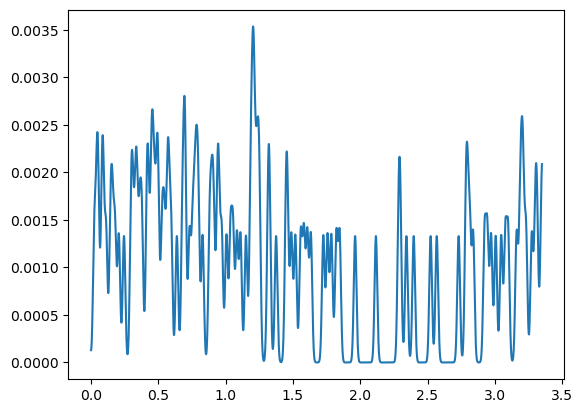

In [8]:
cl = 12

#firing time open
fire_time_old = df_m13_20.loc[df_m13_20['cluster_id']==cl].iloc[0]['firing_times']

#smoothing
sigm = 0.01 * 30000
fire_time_old= fire_time_old.astype(int)
l = max(fire_time_old) + 1
signal = np.zeros(l)
signal[fire_time_old] = 1
%time signal = gaussian_filter1d(signal, sigm)

#plot
sign_time = np.arange(len(signal))
sign_time = sign_time / 30000
print(max(sign_time))
plt.plot(sign_time[:100500],signal[:100500])

#cut time to interval 0s-1400s
tr_np = makebasNpfromRow(df_m13_20.iloc[0])
mask = (tr_np[:, 0] >= 0) & (tr_np[:, 0] <= 1400)
tr_np = tr_np[mask, :]

sign_np = np.dstack((sign_time, signal))
sign_np = sign_np[0]
#время от 0 с до 1400
mask = (sign_np[:, 0] >= 0) & (sign_np[:, 0] <= 1400)
sign_np = sign_np[mask, :]


In [10]:
new_dt = 0.00333
num_new_points = int (1400 / new_dt)

#блин мне порю не хватает RAM для этой ячейки
#нужно взять не signal а sign_np!!!!!!!!!!!!!!!!!!!!!!!!! TODO 
%time new_sign = resample(sign_np[:,1], num_new_points, axis=0)

resampled_dfnp = resample(tr_np[:, 1:], num_new_points, axis=0)
new_time = np.linspace(0, 1400, )
#new_sign = resample(sign_np[:, 1:], num_new_points, axis=0)
resampled_df['signal'+str(cl)] = new_sign

CPU times: total: 17.9 s
Wall time: 2min 14s


In [12]:
resampled_df

time           x          y      signal17   signal6  signal12
0          0.00000   95.075018   7.693317  6.071836e-10  0.001022  0.000077
1          0.00333  100.186379   6.587274 -6.029137e-10 -0.000185  0.000176
2          0.00666  103.843984   5.798661  5.987792e-10  0.000100  0.000274
3          0.00999  106.052412   5.325915 -5.947755e-10 -0.000068  0.000471
4          0.01332  106.896233   5.150192  5.908982e-10  0.000051  0.000720
...            ...         ...        ...           ...       ...       ...
420415  1399.98668   53.109383  16.836155 -6.307439e-10  0.001921  0.000391
420416  1399.99001   62.833622  14.709746  6.257187e-10  0.001879  0.000209
420417  1399.99334   72.204922  12.664988 -6.208559e-10  0.002085  0.000096
420418  1399.99667   80.887685  10.774176  6.161495e-10  0.001992  0.000049
420419  1400.00000   88.588777   9.100306 -6.115939e-10  0.002289  0.000015

[420420 rows x 6 columns]

In [13]:
resampled_df.to_pickle('new_M13_2018-04-23_09-34-20_of_17.pkl')

###### 1.4.3 add signal 15

CPU times: total: 59.6 s
Wall time: 1min 3s
1471.2119666666667


NameError: name 'makebasNpfromRow' is not defined

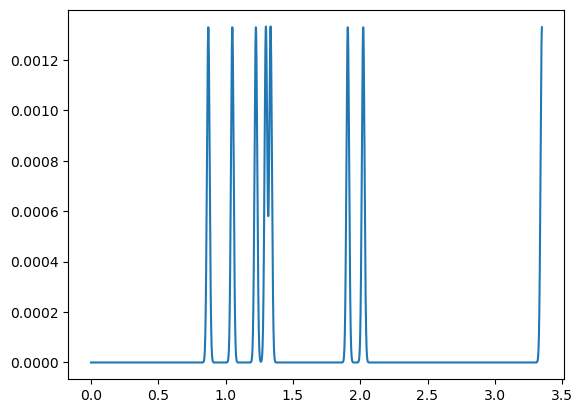

In [7]:
cl = 15

#firing time open
fire_time_old = df_m13_20.loc[df_m13_20['cluster_id']==cl].iloc[0]['firing_times']

#smoothing
sigm = 0.01 * 30000
fire_time_old= fire_time_old.astype(int)
l = max(fire_time_old) + 1
signal = np.zeros(l)
signal[fire_time_old] = 1
%time signal = gaussian_filter1d(signal, sigm)

#plot
sign_time = np.arange(len(signal))
sign_time = sign_time / 30000
print(max(sign_time))
plt.plot(sign_time[:100500],signal[:100500])

#cut time to interval 0s-1400s
tr_np = makebasNpfromRow(df_m13_20.iloc[0])
mask = (tr_np[:, 0] >= 0) & (tr_np[:, 0] <= 1400)
tr_np = tr_np[mask, :]

sign_np = np.dstack((sign_time, signal))
sign_np = sign_np[0]
#время от 0 с до 1400
mask = (sign_np[:, 0] >= 0) & (sign_np[:, 0] <= 1400)
sign_np = sign_np[mask, :]


In [9]:
#cut time to interval 0s-1400s
tr_np = makebasNpfromRow(df_m13_20.iloc[0])
mask = (tr_np[:, 0] >= 0) & (tr_np[:, 0] <= 1400)
tr_np = tr_np[mask, :]

sign_np = np.dstack((sign_time, signal))
sign_np = sign_np[0]
#время от 0 с до 1400
mask = (sign_np[:, 0] >= 0) & (sign_np[:, 0] <= 1400)
sign_np = sign_np[mask, :]

In [10]:
new_dt = 0.00333
num_new_points = int (1400 / new_dt)

#блин мне порю не хватает RAM для этой ячейки

%time new_sign = resample(sign_np[:,1], num_new_points, axis=0)

resampled_dfnp = resample(tr_np[:, 1:], num_new_points, axis=0)
new_time = np.linspace(0, 1400, )
#new_sign = resample(sign_np[:, 1:], num_new_points, axis=0)
resampled_df['signal'+str(cl)] = new_sign

CPU times: total: 18.6 s
Wall time: 54.3 s


In [11]:
resampled_df

time           x          y      signal17   signal6  signal12  \
0          0.00000   95.075018   7.693317  6.071836e-10  0.001022  0.000077   
1          0.00333  100.186379   6.587274 -6.029137e-10 -0.000185  0.000176   
2          0.00666  103.843984   5.798661  5.987792e-10  0.000100  0.000274   
3          0.00999  106.052412   5.325915 -5.947755e-10 -0.000068  0.000471   
4          0.01332  106.896233   5.150192  5.908982e-10  0.000051  0.000720   
...            ...         ...        ...           ...       ...       ...   
420415  1399.98668   53.109383  16.836155 -6.307439e-10  0.001921  0.000391   
420416  1399.99001   62.833622  14.709746  6.257187e-10  0.001879  0.000209   
420417  1399.99334   72.204922  12.664988 -6.208559e-10  0.002085  0.000096   
420418  1399.99667   80.887685  10.774176  6.161495e-10  0.001992  0.000049   
420419  1400.00000   88.588777   9.100306 -6.115939e-10  0.002289  0.000015   

            signal15  
0      -1.605840e-12  
1      -7.956076e-13  
2       3.150126e-12  
3      -5.459456e-12  
4       7.725268e-12  
...              ...  
420415  1.438331e-11  
420416 -1.171839e-11  
420417  9.110289e-12  
420418 -6.556856e-12  
420419  4.056031e-12  

[420420 rows x 7 columns]

In [12]:
resampled_df.to_pickle('new_M13_2018-04-23_09-34-20_of_17.pkl')

#### 2.check neuro recording in 1 session

##### 2.1. plot recording of 4 neurons in different intervals of recording

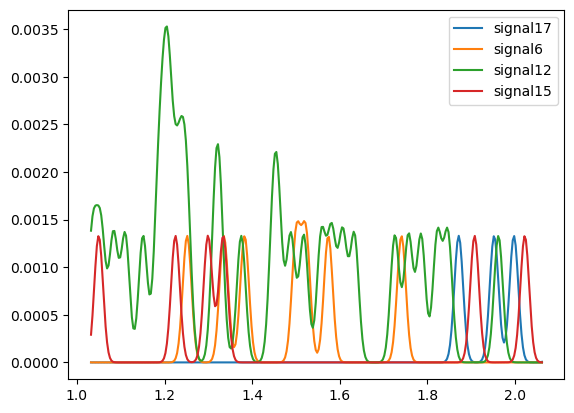

In [14]:
rang = resampled_df.iloc[310:620]
plt.plot(rang['time'], rang['signal17'], label='signal17')
plt.plot(rang['time'], rang['signal6'], label='signal6')
plt.plot(rang['time'], rang['signal12'], label='signal12')
plt.plot(rang['time'], rang['signal15'], label='signal15')
plt.legend()

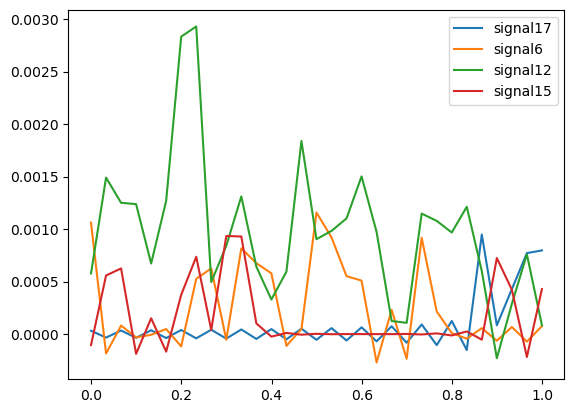

In [22]:
# rang = resampled_df.iloc[0:31]
# plt.plot(rang['time'], rang['signal17'], label='signal17')
# plt.plot(rang['time'], rang['signal6'], label='signal6')
# plt.plot(rang['time'], rang['signal12'], label='signal12')
# plt.plot(rang['time'], rang['signal15'], label='signal15')
# plt.legend()

In [31]:
print(60 * 15 * 30)

27000


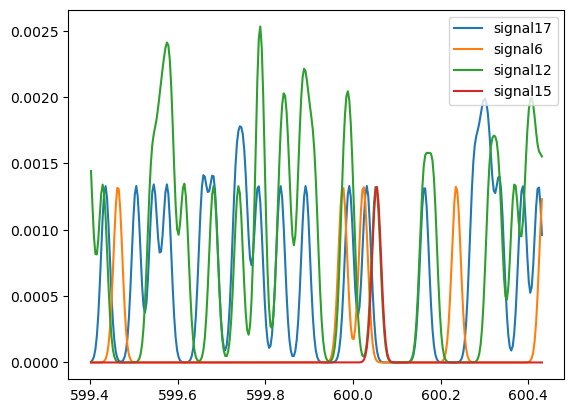

In [15]:
rang = resampled_df.iloc[180000:180310]
plt.plot(rang['time'], rang['signal17'], label='signal17')
plt.plot(rang['time'], rang['signal6'], label='signal6')
plt.plot(rang['time'], rang['signal12'], label='signal12')
plt.plot(rang['time'], rang['signal15'], label='signal15')
plt.legend()

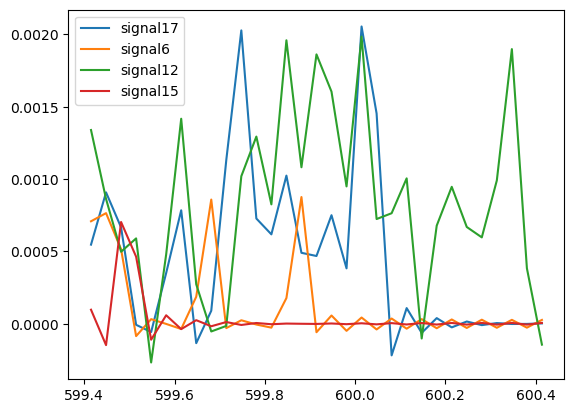

In [23]:
rang = resampled_df.iloc[18000:18031]
plt.plot(rang['time'], rang['signal17'], label='signal17')
plt.plot(rang['time'], rang['signal6'], label='signal6')
plt.plot(rang['time'], rang['signal12'], label='signal12')
plt.plot(rang['time'], rang['signal15'], label='signal15')
plt.legend()

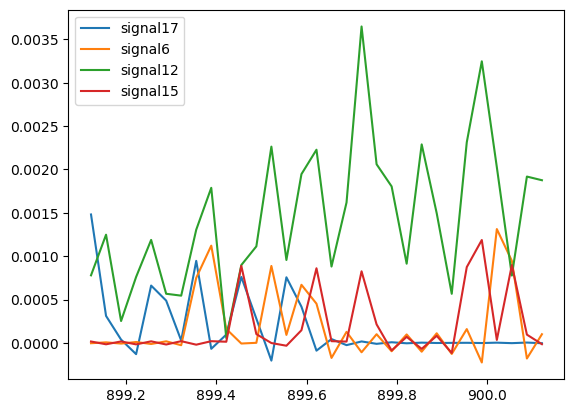

In [27]:
rang = resampled_df.iloc[27000:27031]
plt.plot(rang['time'], rang['signal17'], label='signal17')
plt.plot(rang['time'], rang['signal6'], label='signal6')
plt.plot(rang['time'], rang['signal12'], label='signal12')
plt.plot(rang['time'], rang['signal15'], label='signal15')
plt.legend()

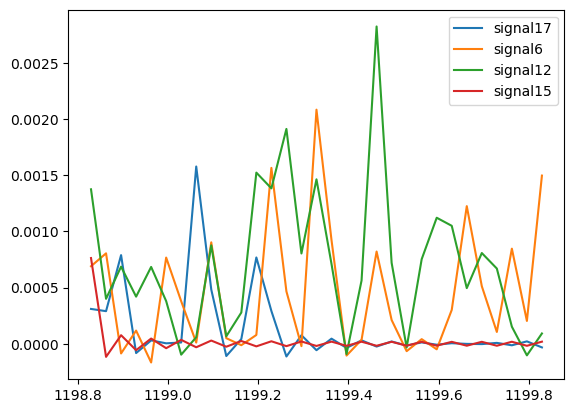

In [24]:
rang = resampled_df.iloc[36000:36031]
plt.plot(rang['time'], rang['signal17'], label='signal17')
plt.plot(rang['time'], rang['signal6'], label='signal6')
plt.plot(rang['time'], rang['signal12'], label='signal12')
plt.plot(rang['time'], rang['signal15'], label='signal15')
plt.legend()

##### 2.2 plot neurons in area boundary crossings

###### 2.2.1 check square / circle open field, take recording fron square open field (df_sq)

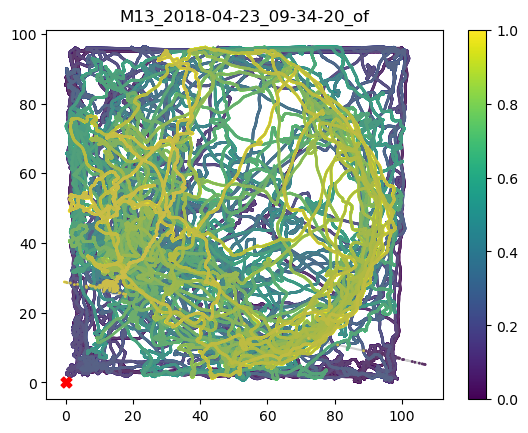

In [16]:
plot_trajectory(resampled_df['x'],resampled_df['y'],title='M13_2018-04-23_09-34-20_of')
#я вот еще не нахожу точного момента когда мышь переместили из квадратного открытого поля в круглое

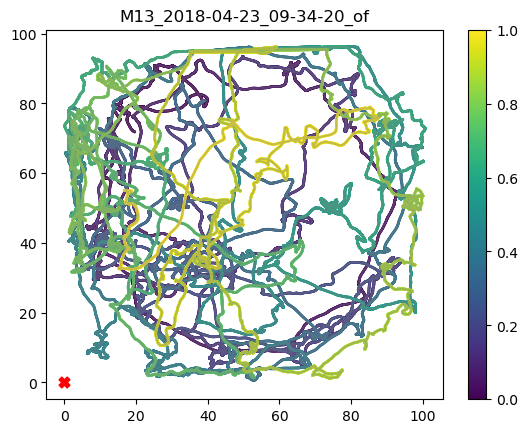

In [17]:
df = resampled_df.loc[(resampled_df['time']>=600) & (resampled_df['time']<=1000)]
plot_trajectory(df['x'],df['y'],title='M13_2018-04-23_09-34-20_of')

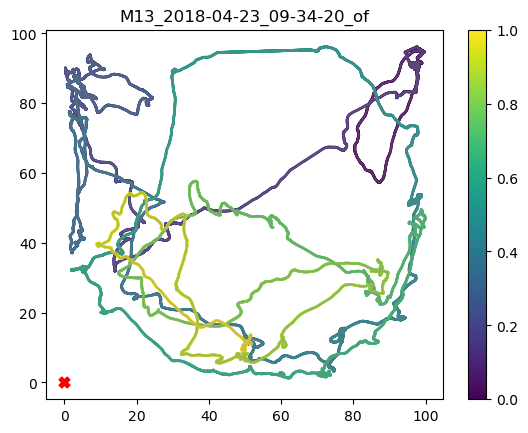

In [18]:
df = resampled_df.loc[(resampled_df['time']>=350) & (resampled_df['time']<=450)]
plot_trajectory(df['x'],df['y'],title='M13_2018-04-23_09-34-20_of')

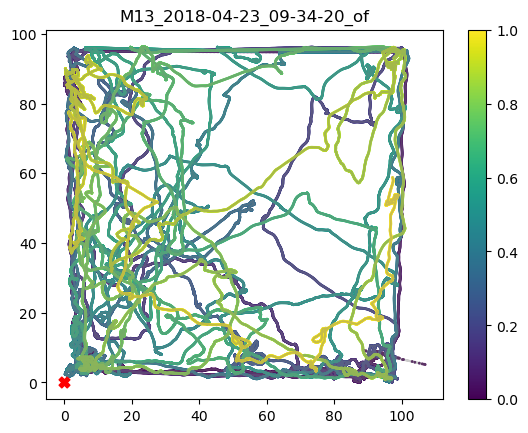

In [19]:
df_sq = resampled_df.loc[(resampled_df['time']>=0) & (resampled_df['time']<=400)]
plot_trajectory(df_sq['x'],df_sq['y'],title='M13_2018-04-23_09-34-20_of')

###### 2.2.2 add area demarkation

In [20]:
#df_sq = df_sq.dropna()
AREA_SIZE = [-40, 40]
rescaled_x = rescale_coord(df_sq['x'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
rescaled_y = rescale_coord(df_sq['y'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
df_sq.loc[:, 'x'] = rescaled_x
df_sq.loc[:, 'y'] = rescaled_y
bord40 =  {'xmin': -40,'xmax': 40,'ymin': -40,'ymax': 40} 
df_sq = sort_walls_area_simple(df_sq, bord40, 0.1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22760\2570194419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sq.loc[:, 'x'] = rescaled_x
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22760\2570194419.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sq.loc[:, 'y'] = rescaled_y
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22760\1467551385.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [21]:
df_sq['near_wall'].value_counts()

5.0     59396
0.0     41636
50.0    19088
Name: near_wall, dtype: int64

In [22]:
df_sq['area_change'] = df_sq['near_wall'].diff()
wall_to_corner_times = df_sq.loc[df_sq['area_change']==45]['time'].to_numpy()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22760\3680269013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sq['area_change'] = df_sq['near_wall'].diff()


In [24]:
len(wall_to_corner_times)

50

In [25]:
signals = df_sq.columns.to_list()
signals = [i for i in signals if 'signal' in i]

In [26]:
def plot1s(df, t, signals_list):
    t1 = t-0.5
    t2 = t+0.5
    df = df.loc[(df['time']>=t1)&(df['time']<=t2)]
    plt.figure(figsize=(5,3))
    for s in signals_list:
        plt.plot(df['time'], df[s], label=s)
    plt.axvline(x=t, color='m')
    plt.legend()
    plt.show()

In [30]:
wall_to_corner_times = wall_to_corner_times[wall_to_corner_times>1]

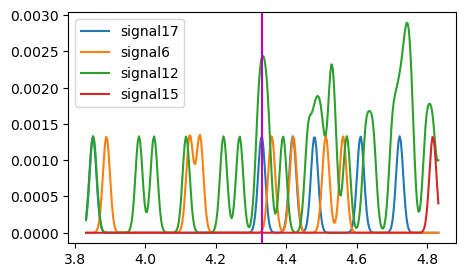

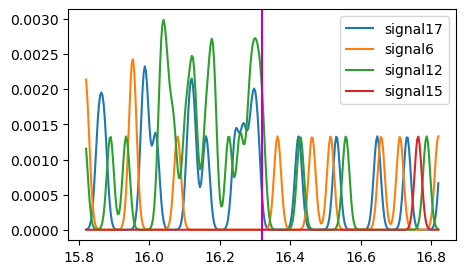

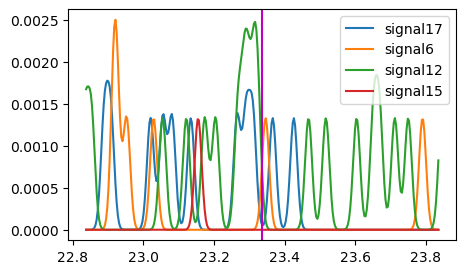

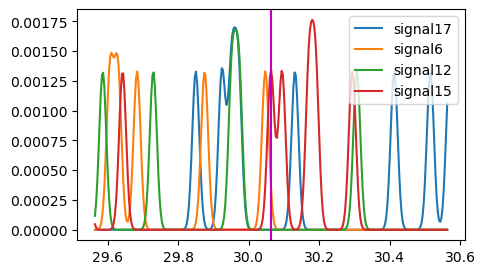

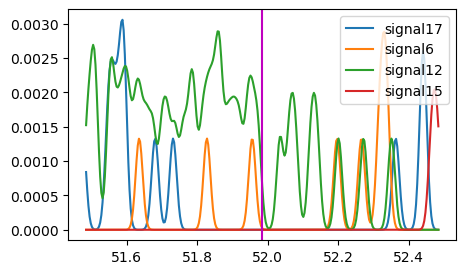

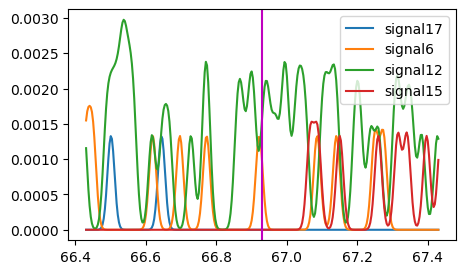

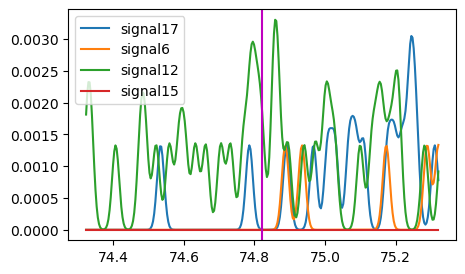

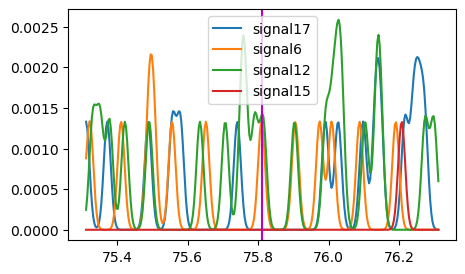

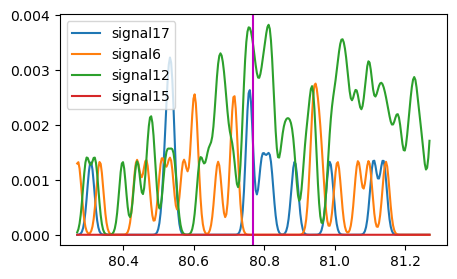

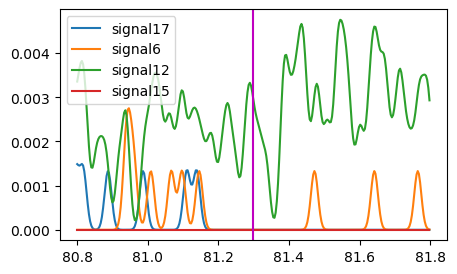

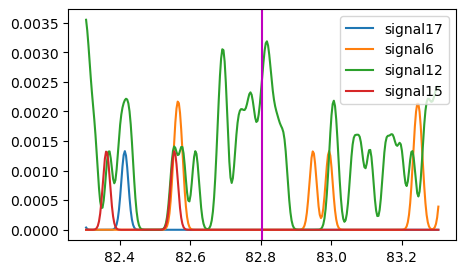

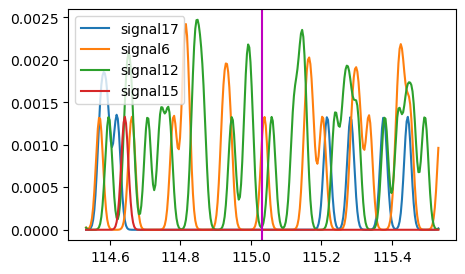

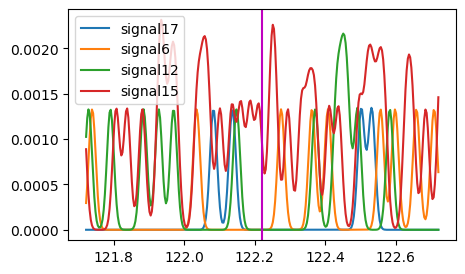

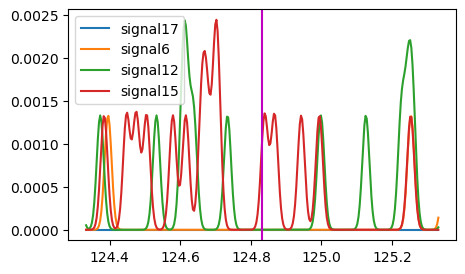

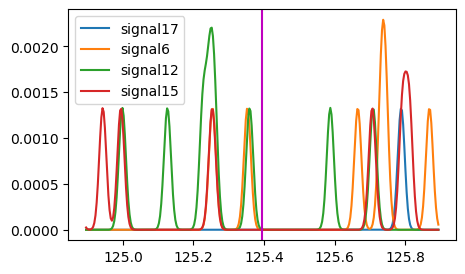

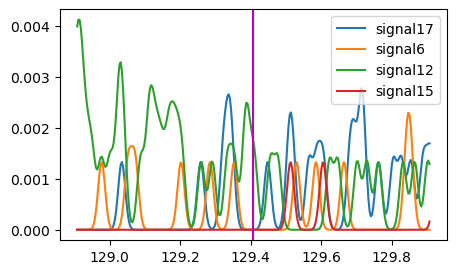

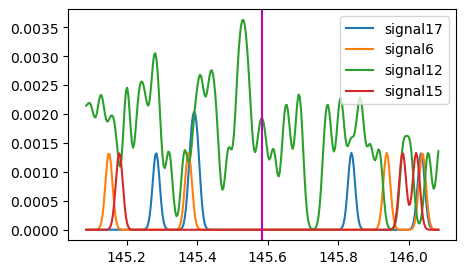

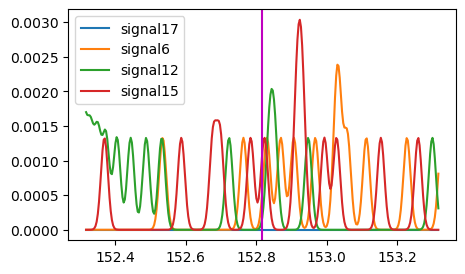

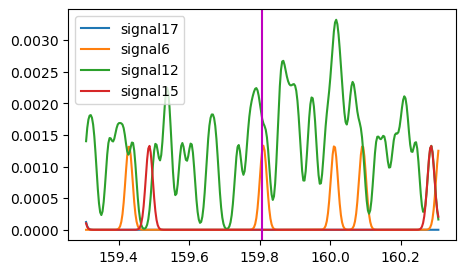

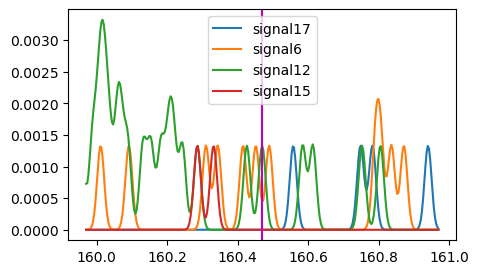

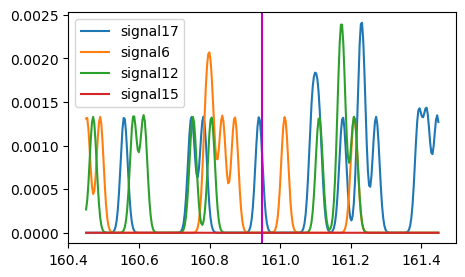

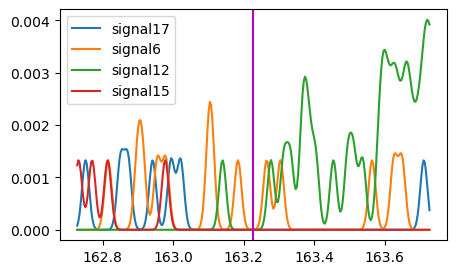

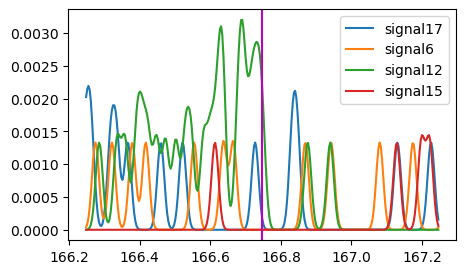

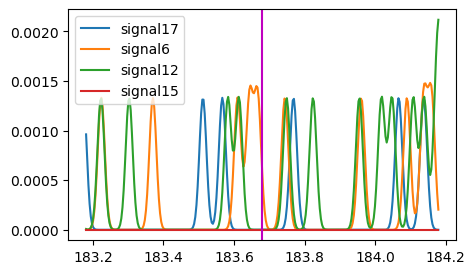

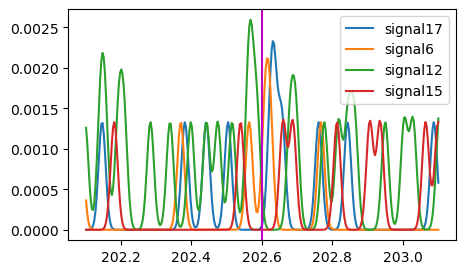

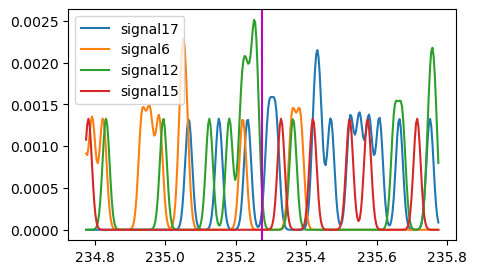

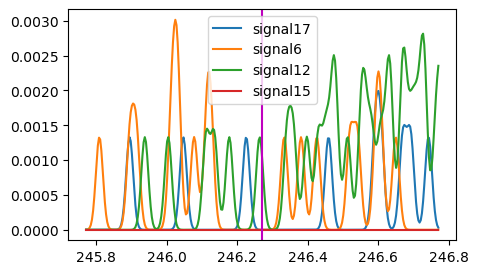

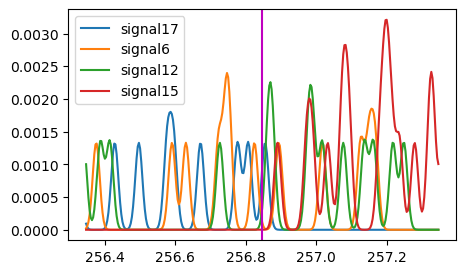

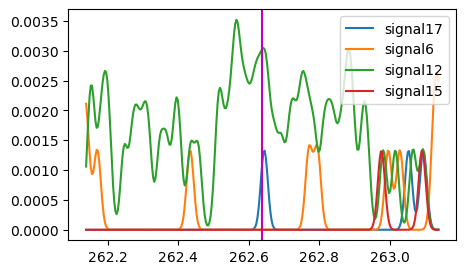

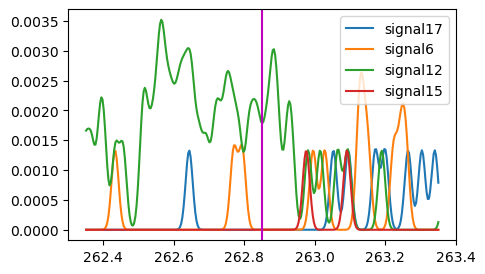

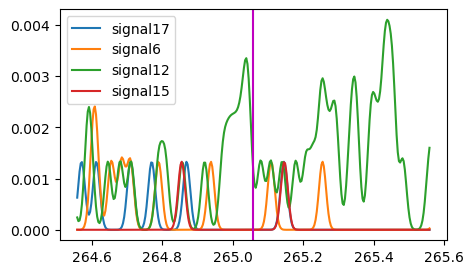

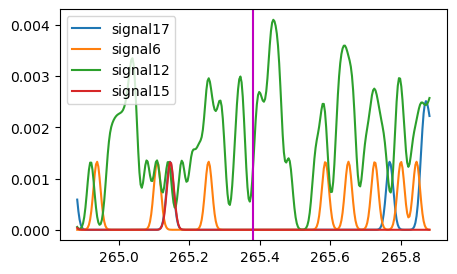

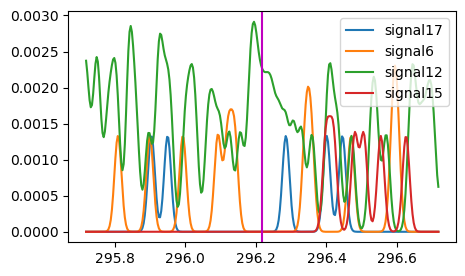

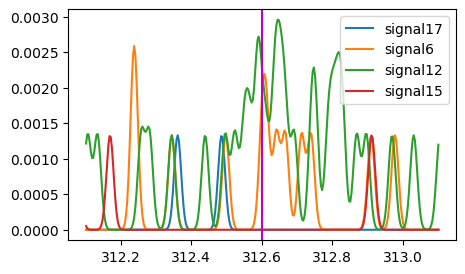

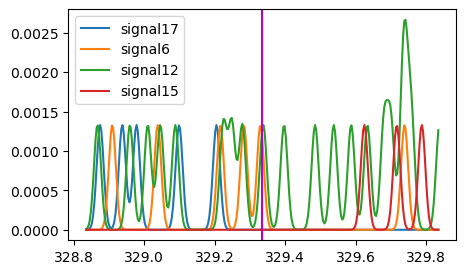

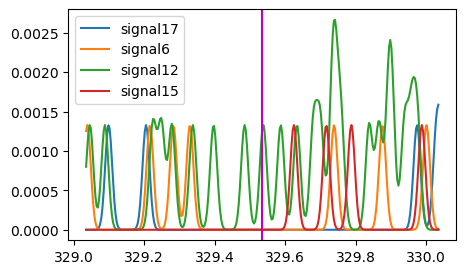

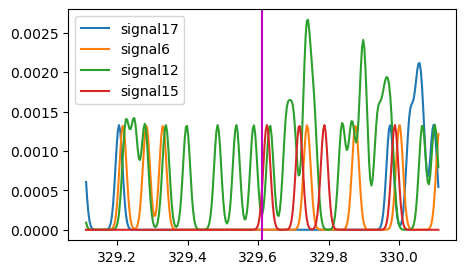

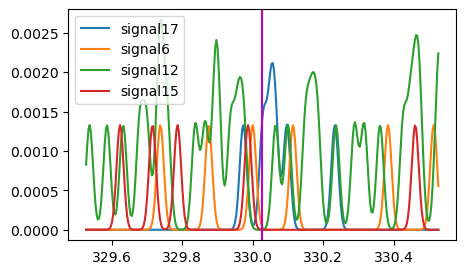

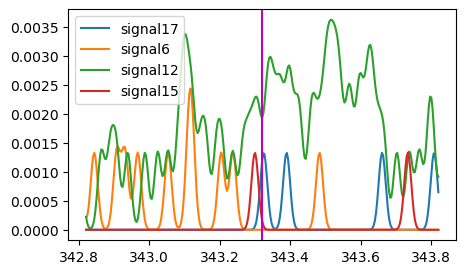

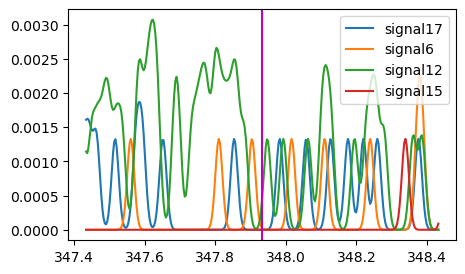

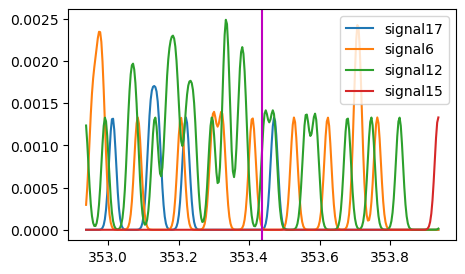

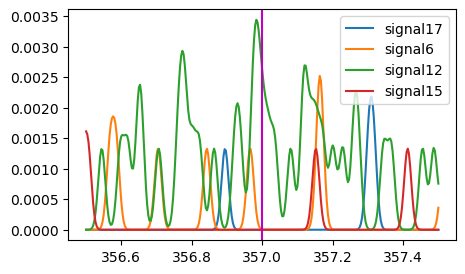

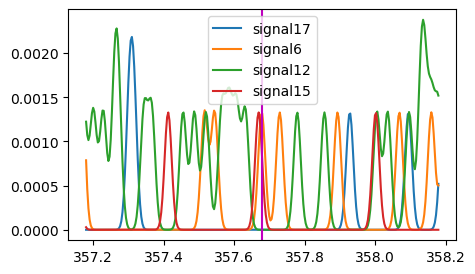

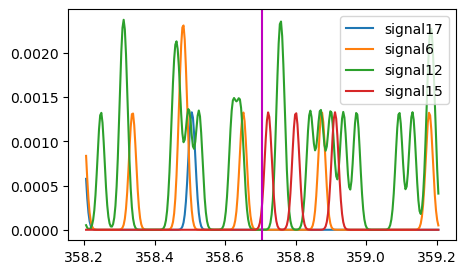

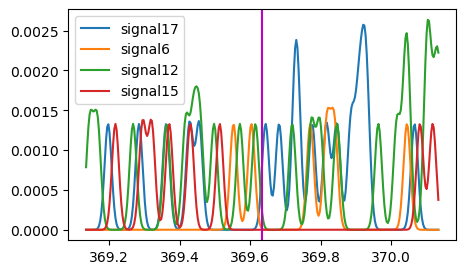

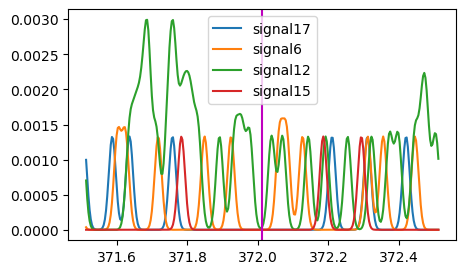

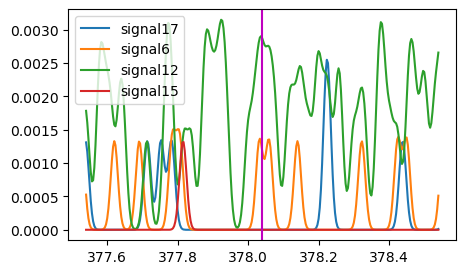

In [31]:
for i in wall_to_corner_times:
    plot1s(df_sq, i, signals)